### 1. Load packages

In [1]:
import time

In [3]:
!pip install tinkoff-investments

In [5]:
TOKEN = '' #боевой M13

In [6]:
from tinkoff.invest import Client
#from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX 


# with Client(TOKEN, target=INVEST_GRPC_API_SANDBOX ) as client:
#     print(client.users.get_accounts())


with Client(TOKEN) as client:
    print(client.users.get_accounts())

GetAccountsResponse(accounts=[Account(id='2169433725', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='M13', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2022, 4, 27, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_READ_ONLY: 2>)])


### 2. Load data

In [10]:
import logging
import os

import pandas as pd

from tinkoff.invest import Client, SecurityTradingStatus
from tinkoff.invest.services import InstrumentsService
from tinkoff.invest.utils import quotation_to_decimal

from IPython.display import clear_output

In [13]:
def get_figi(ticker):
    with Client(TOKEN) as client:
        instruments: InstrumentsService = client.instruments
        tickers = []
        for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
            for item in getattr(instruments, method)().instruments:
                tickers.append(
                    {
                        "name": item.name,
                        "ticker": item.ticker,
                        "class_code": item.class_code,
                        "figi": item.figi,
                        "uid": item.uid,
                        "type": method,
                        "min_price_increment": quotation_to_decimal(
                            item.min_price_increment
                        ),
                        "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                        "lot": item.lot,
                        "trading_status": str(
                            SecurityTradingStatus(item.trading_status).name
                        ),
                        "api_trade_available_flag": item.api_trade_available_flag,
                        "currency": item.currency,
                        "exchange": item.exchange,
                        "buy_available_flag": item.buy_available_flag,
                        "sell_available_flag": item.sell_available_flag,
                        "short_enabled_flag": item.short_enabled_flag,
                        "klong": quotation_to_decimal(item.klong),
                        "kshort": quotation_to_decimal(item.kshort),
                    }
                )

        tickers_df = pd.DataFrame(tickers)

        ticker_df = tickers_df[tickers_df["ticker"] == ticker]
        #return ticker_df
        if ticker_df.empty:
            print("There is no such ticker: %s", ticker)
            return

        figi = ticker_df["figi"].iloc[0]
        return figi


def get_info():
    with Client(TOKEN) as client:
        instruments: InstrumentsService = client.instruments
        tickers = []
        for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
            for item in getattr(instruments, method)().instruments:
                tickers.append(
                    {
                        "name": item.name,
                        "ticker": item.ticker,
                        "class_code": item.class_code,
                        "figi": item.figi,
                        "uid": item.uid,
                        "type": method,
                        "min_price_increment": quotation_to_decimal(
                            item.min_price_increment
                        ),
                        "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                        "lot": item.lot,
                        "trading_status": str(
                            SecurityTradingStatus(item.trading_status).name
                        ),
                        "api_trade_available_flag": item.api_trade_available_flag,
                        "currency": item.currency,
                        "exchange": item.exchange,
                        "buy_available_flag": item.buy_available_flag,
                        "sell_available_flag": item.sell_available_flag,
                        "short_enabled_flag": item.short_enabled_flag,
                        "klong": quotation_to_decimal(item.klong),
                        "kshort": quotation_to_decimal(item.kshort),
                    }
                )

        tickers_df = pd.DataFrame(tickers)
    return tickers_df

In [16]:
import os
from datetime import timedelta
import datetime

from tqdm import tqdm
import numpy as np

from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.utils import now

    
def get_all_candles(ticker=None, from_=None, to_=None, interval=None):
    
    figi = get_figi(ticker)
    
    with Client(TOKEN) as client:
        
        data = [elem for elem in client.get_all_candles(figi=figi, 
                                      from_=from_-timedelta(hours=3),
                                      to=to_- timedelta(hours=3),
                                     interval=interval
                                    )
               ]

    
    #open_ = np.zeros(len(data))
    #high = np.zeros(len(data))
    #low = np.zeros(len(data))
    close = np.zeros(len(data))
    volume = np.zeros(len(data))
    times = np.zeros(len(data), dtype='O')
    for i, elem in enumerate(data):
        #open_[i] = quotation_to_decimal(elem.open)
        #high[i] = quotation_to_decimal(elem.high)
        #low[i] = quotation_to_decimal(elem.low)
        close[i] = quotation_to_decimal(elem.close)
        volume[i] = elem.volume
        times[i] = elem.time


    df = pd.DataFrame({'time' : times,
                      #'open' : open_,
                      'close' : close,
                      'volume' : volume,
                      #'low' : low,
                      #'high' : high
                    })
    df['time'] += pd.Timedelta(hours=3)
    return df

### -1


In [20]:
get_figi('SFIN')

'BBG003LYCMB1'

In [21]:
ticker = 'T'
#2024-06-10 
data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2024, 6, 10, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 6, 12, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )

data['ticker'] = ticker
data

,time,close,volume,ticker
0,2024-06-10 09:00:00+00:00,2974.0,1846.0,T
1,2024-06-10 10:00:00+00:00,2989.0,252336.0,T
2,2024-06-10 11:00:00+00:00,2976.0,106799.0,T
3,2024-06-10 12:00:00+00:00,2977.6,139763.0,T
4,2024-06-10 13:00:00+00:00,2973.6,64276.0,T
5,2024-06-10 14:00:00+00:00,2974.0,66350.0,T
6,2024-06-10 15:00:00+00:00,2948.6,133118.0,T
7,2024-06-10 16:00:00+00:00,2947.0,69133.0,T
8,2024-06-10 17:00:00+00:00,2930.6,86918.0,T
9,2024-06-10 18:00:00+00:00,2898.0,161966.0,T


In [24]:
data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2024, 6, 10, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 6, 12, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_DAY
                      )

data['ticker'] = ticker
data

,time,close,volume,ticker
0,2024-06-10 03:00:00+00:00,2886.6,1391052.0,T
1,2024-06-11 03:00:00+00:00,2890.6,1160771.0,T


### -1

In [86]:
%%time

ticker = 'TMOS'

data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2025, 1, 1, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2025, 1, 10, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )

data['ticker'] = ticker

CPU times: user 719 ms, sys: 7.36 ms, total: 727 ms
Wall time: 1.22 s


In [87]:
data

,time,close,volume,ticker
0,2025-01-03 09:00:00+00:00,6.31,81165.0,TMOS
1,2025-01-03 10:00:00+00:00,6.20,12405231.0,TMOS
2,2025-01-03 11:00:00+00:00,6.19,4224743.0,TMOS
3,2025-01-03 12:00:00+00:00,6.14,5029243.0,TMOS
4,2025-01-03 13:00:00+00:00,6.14,4735730.0,TMOS
5,2025-01-03 14:00:00+00:00,6.14,6350496.0,TMOS
6,2025-01-03 15:00:00+00:00,6.14,1389740.0,TMOS
7,2025-01-03 16:00:00+00:00,6.14,2190425.0,TMOS
8,2025-01-03 17:00:00+00:00,6.15,2098042.0,TMOS
9,2025-01-03 18:00:00+00:00,6.15,695071.0,TMOS


In [89]:
!mkdir data

mkdir: data: File exists


In [93]:
!mkdir data/raw

mkdir: data/raw: File exists


In [95]:
!mkdir data/raw/5min

mkdir: data/raw/5min: File exists


In [97]:
!mkdir data/raw/1hour

mkdir: data/raw/1hour: File exists


In [99]:
!mkdir data/raw/1day

mkdir: data/raw/1day: File exists


In [34]:
import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### Отберем ликвидные акции

In [110]:
stocks = ['AFLT',
 'IRAO',
 'MVID',
 'OGKB',
 'SPBE',
 'MTLRP',
 'SFIN',
 'KMAZ',
 'CBOM',
 'MSNG',
 'FEES',
 'LKOH',
 'FESH',
 'KROT',
 'LENT',
 'MDMG',
 'NKNCP',
 'VKCO',
 'UPRO',
 'MRKY',
 'SELG',
 'SGZH',
 'AKRN',
 'CHMK',
 'ENPG',
 'YAKG',
 'PMSBP',
 'RKKE',
 'GEMC',
 'LSRG',
 'MRKZ',
 'BANE',
 'CNTL',
 'PMSB',
 'KRKNP',
 'NMTP',
 'PLZL',
 'TATN',
 'AFKS',
 'UNKL',
 'APTK',
 'LNZL',
 'GMKN',
 'NSVZ',
 'LIFE',
 'RNFT',
 'VRSB',
 'YDEX',
 'UWGN',
 'TGKN',
 'ABRD',
 'HYDR',
 'ABIO',
 'WUSH',
 'RTKMP',
 'GTRK',
 'NLMK',
 'TATNP',
 'CNTLP',
 'BLNG',
 'ALRS',
 'GCHE',
 'VSMO',
 'LSNG',
 'TRNFP',
 'MGNT',
 'RENI',
 'NKHP',
 'TGKB',
 'ROLO',
 'IRKT',
 'MGTSP',
 'MTLR',
 'TGKA',
 'MSRS',
 'HEAD',
 'RUAL',
 'MRKV',
 'KLSB',
 'SIBN',
 'SNGS',
 'MSTT',
 'KAZTP',
 'DVEC',
 'NVTK',
 'RASP',
 'VTBR',
 'PHOR',
 'TTLK',
 'NKNC',
 'T',
 'KAZT',
 'AMEZ',
 'MRKU',
 'TRMK',
 'MOEX',
 'SBERP',
 #'VEON-RX',
 'CHMF',
 'RTKM',
 'SMLT',
 'LNZLP',
 'MRKC',
 'MRKP',
 'UNAC',
 'KZOSP',
 'GAZP',
 'ROSN',
 'BELU',
 'ELFV',
 'FLOT',
 'PIKK',
 'LSNGP',
 'SVAV',
 'TGKBP',
 'POSI',
 'KZOS',
 'MRKS',
 'SNGSP',
 'MTSS',
 'MAGN',
 'PRFN',
 'SBER',
 'BANEP',
 'BSPB',
 'AQUA',
 'RBCM']

In [112]:
data = []
for stock in stocks:
    df = load_pkl(f"../money_v3/data/raw/1day/{stock}.pkl")
    df = df[df['time'] > datetime.datetime(2025, 1, 1, tzinfo=datetime.timezone.utc)]
    data += [df]
data = pd.concat(data)

data = data.groupby('ticker').apply(lambda x: pd.Series({'mean_volume' :  x['volume'].mean(),
                                                         'mean_close' : x['close'].mean()}))
data

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_75878/1407591603.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('ticker').apply(lambda x: pd.Series({'mean_volume' :  x['volume'].mean(),


,mean_volume,mean_close
ticker,,
ABIO,1.996380e+05,90.305455
ABRD,1.130664e+04,186.772727
AFKS,1.342772e+06,14.786773
AFLT,3.610632e+06,61.276818
AKRN,4.325909e+02,17686.636364
ALRS,2.243179e+06,56.313636
AMEZ,6.639273e+03,71.109091
APTK,5.555096e+05,11.892182
AQUA,9.437355e+04,634.681818


In [114]:
data_info = get_info()
data_info

,name,ticker,class_code,figi,uid,type,min_price_increment,scale,lot,trading_status,api_trade_available_flag,currency,exchange,buy_available_flag,sell_available_flag,short_enabled_flag,klong,kshort
0,CNX Resources Corporation,CNX,SPBXM,BBG000CKVSG8,82f8d11f-0307-45c3-bb94-8758a2f673a3,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
1,SLM Corp,SLM,SPBXM,BBG000BBCQD7,f8e85601-10e3-4af6-a44b-b7d2ca3f7f62,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
2,Axcelis Technologies,ACLS,SPBXM,BBG000DW34S2,98da7119-dc33-4567-ae41-1944f6f49334,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
3,Amphastar Pharmaceuticals,AMPH,SPBXM,BBG000BW90S6,c1ad8284-45de-468f-8a37-271f254ae601,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
4,Remitly Global,RELY,SPBXM,BBG012C7JST2,fb4f9c78-ba9a-4733-be60-50d6eacea5e0,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,BANE-6.25 Башнефть,BNM5,SPBFUT,FUTBANE06250,a4811010-1dcf-4bb3-ac83-4c83a507834e,futures,1.00000000,9,1,SECURITY_TRADING_STATUS_NORMAL_TRADING,True,rub,FORTS_EVENING,True,True,True,2.00000000,2.00000000
3829,MMI-6.25 Индекс Металлов и добычи,MAM5,SPBFUT,FUTMMI062500,742d7110-045f-4166-b24f-6019b385eeba,futures,1.00000000,9,1,SECURITY_TRADING_STATUS_NORMAL_TRADING,True,rub,FORTS_EVENING,True,True,True,2.00000000,2.00000000
3830,RTSM-9.25 Индекс РТС (мини),RMU5,SPBFUT,FUTRTSM09250,106e6bcb-627d-4ad7-8e96-141527bbdbd1,futures,0.50000000,1,1,SECURITY_TRADING_STATUS_NORMAL_TRADING,True,rub,FORTS_EVENING,True,True,True,2.00000000,2.00000000
3831,BR-5.25 Нефть Brent,BRK5,SPBFUT,FUTBR0525000,162b7aab-c5b1-45d2-9353-363dad9510c1,futures,0.01000000,2,1,SECURITY_TRADING_STATUS_NORMAL_TRADING,True,rub,FORTS_EVENING,True,True,True,2.00000000,2.00000000


In [117]:
data = data.merge(data_info[['ticker', 'lot']], on='ticker', how='left')
data

,ticker,mean_volume,mean_close,lot
0,ABIO,1.996380e+05,90.305455,10
1,ABRD,1.130664e+04,186.772727,10
2,AFKS,1.342772e+06,14.786773,100
3,AFLT,3.610632e+06,61.276818,10
4,AKRN,4.325909e+02,17686.636364,1
5,ALRS,2.243179e+06,56.313636,10
6,AMEZ,6.639273e+03,71.109091,100
7,APTK,5.555096e+05,11.892182,10
8,AQUA,9.437355e+04,634.681818,1
9,BANE,3.183355e+04,2494.431818,1


In [119]:
data['ticker'].value_counts()

ticker
T        2
ABIO     1
SBER     1
RTKMP    1
RTKM     1
ROSN     1
ROLO     1
RNFT     1
RKKE     1
RENI     1
RBCM     1
RASP     1
PRFN     1
POSI     1
PMSBP    1
PMSB     1
PLZL     1
PIKK     1
PHOR     1
OGKB     1
NVTK     1
NSVZ     1
NMTP     1
NLMK     1
NKNCP    1
NKNC     1
NKHP     1
MVID     1
MTSS     1
MTLRP    1
MTLR     1
RUAL     1
SBERP    1
ABRD     1
SELG     1
YAKG     1
WUSH     1
VTBR     1
VSMO     1
VRSB     1
VKCO     1
UWGN     1
UPRO     1
UNKL     1
UNAC     1
TTLK     1
TRNFP    1
TRMK     1
TGKN     1
TGKBP    1
TGKB     1
TGKA     1
TATNP    1
TATN     1
SVAV     1
SPBE     1
SNGSP    1
SNGS     1
SMLT     1
SIBN     1
SGZH     1
SFIN     1
MSTT     1
MSRS     1
MSNG     1
CHMK     1
GTRK     1
GMKN     1
GEMC     1
GCHE     1
GAZP     1
FLOT     1
FESH     1
FEES     1
ENPG     1
ELFV     1
DVEC     1
CNTLP    1
CNTL     1
CHMF     1
MRKZ     1
CBOM     1
BSPB     1
BLNG     1
BELU     1
BANEP    1
BANE     1
AQUA     1
APTK     1
AMEZ     1
ALR

In [122]:
data['liquid_cap'] = data['mean_volume']*data['mean_close']*data['lot'] / 1e6
data

,ticker,mean_volume,mean_close,lot,liquid_cap
0,ABIO,1.996380e+05,90.305455,10,180.283962
1,ABRD,1.130664e+04,186.772727,10,21.117713
2,AFKS,1.342772e+06,14.786773,100,1985.526372
3,AFLT,3.610632e+06,61.276818,10,2212.480267
4,AKRN,4.325909e+02,17686.636364,1,7.651078
5,ALRS,2.243179e+06,56.313636,10,1263.215819
6,AMEZ,6.639273e+03,71.109091,100,47.211265
7,APTK,5.555096e+05,11.892182,10,66.062211
8,AQUA,9.437355e+04,634.681818,1,59.897173
9,BANE,3.183355e+04,2494.431818,1,79.406609


In [124]:
pd.set_option('display.max_rows', 130)
data.sort_values(by='liquid_cap')

,ticker,mean_volume,mean_close,lot,liquid_cap
35,KAZTP,3.508182e+02,502.295455,10,1.762144
38,KRKNP,2.972727e+02,8138.181818,1,2.419260
111,TGKBP,2.645591e+03,0.012511,100000,3.309995
81,PMSBP,1.288591e+03,280.963636,10,3.620472
18,CNTLP,5.573682e+03,7.618182,100,4.246132
34,KAZT,8.894545e+02,500.509091,10,4.451801
41,KZOSP,2.155391e+04,21.179091,10,4.564922
46,LNZLP,2.721591e+03,1785.227273,1,4.858658
16,CHMK,7.711818e+02,7128.863636,1,5.497650
53,MGTSP,7.077136e+03,871.818182,1,6.169976


In [130]:
(data['liquid_cap'] > 50).sum() - 1 # 100млн руб

76

In [132]:
data.loc[data['liquid_cap'] > 50, 'ticker'].tolist()

['ABIO',
 'AFKS',
 'AFLT',
 'ALRS',
 'APTK',
 'AQUA',
 'BANE',
 'BANEP',
 'BELU',
 'BSPB',
 'CBOM',
 'CHMF',
 'ENPG',
 'FEES',
 'FESH',
 'FLOT',
 'GAZP',
 'GMKN',
 'GTRK',
 'HEAD',
 'HYDR',
 'IRAO',
 'IRKT',
 'KMAZ',
 'LENT',
 'LIFE',
 'LKOH',
 'LSRG',
 'MAGN',
 'MDMG',
 'MGNT',
 'MOEX',
 'MTLR',
 'MTLRP',
 'MTSS',
 'MVID',
 'NLMK',
 'NMTP',
 'NVTK',
 'OGKB',
 'PHOR',
 'PIKK',
 'PLZL',
 'POSI',
 'RASP',
 'RENI',
 'RNFT',
 'ROSN',
 'RTKM',
 'RTKMP',
 'RUAL',
 'SBER',
 'SBERP',
 'SELG',
 'SFIN',
 'SGZH',
 'SIBN',
 'SMLT',
 'SNGS',
 'SNGSP',
 'SPBE',
 'SVAV',
 'T',
 'T',
 'TATN',
 'TATNP',
 'TGKN',
 'TRMK',
 'TRNFP',
 'UNAC',
 'UPRO',
 'UWGN',
 'VKCO',
 'VSMO',
 'VTBR',
 'WUSH',
 'YDEX']

# 1. Get data

In [28]:
stocks = ['ABIO',
 'AFKS',
 'AFLT',
 'ALRS',
 'APTK',
 'AQUA',
 'BANE',
 'BANEP',
 'BELU',
 'BSPB',
 'CBOM',
 'CHMF',
 'ENPG',
 'FEES',
 'FESH',
 'FLOT',
 'GAZP',
 'GMKN',
 'GTRK',
 'HEAD',
 'HYDR',
 'IRAO',
 'IRKT',
 'KMAZ',
 'LENT',
 'LIFE',
 'LKOH',
 'LSRG',
 'MAGN',
 'MDMG',
 'MGNT',
 'MOEX',
 'MTLR',
 'MTLRP',
 'MTSS',
 'MVID',
 'NLMK',
 'NMTP',
 'NVTK',
 'OGKB',
 'PHOR',
 'PIKK',
 'PLZL',
 'POSI',
 'RASP',
 'RENI',
 'RNFT',
 'ROSN',
 'RTKM',
 'RTKMP',
 'RUAL',
 'SBER',
 'SBERP',
 'SELG',
 'SFIN',
 'SGZH',
 'SIBN',
 'SMLT',
 'SNGS',
 'SNGSP',
 'SPBE',
 'SVAV',
 'T',
 'TATN',
 'TATNP',
 'TGKN',
 'TRMK',
 'TRNFP',
 'UNAC',
 'UPRO',
 'UWGN',
 'VKCO',
 'VSMO',
 'VTBR',
 'WUSH',
 'YDEX',


'TMOS',
]

start = datetime.datetime(2022, 7, 1, tzinfo=datetime.timezone.utc)
end = datetime.datetime(2025, 3, 7, tzinfo=datetime.timezone.utc)

In [30]:
len(stocks) #stocks + TMOS

77

In [252]:
#5min

#проблемы со сборкой данных на стороне сервера Т-банка
for i, stock in tqdm(enumerate(stocks)):
    
    dfs = []
    cur_date = start
    while cur_date < end:
    
        flag_data = False
        while not flag_data:
            
            clear_output()
            print(i, 'of', len(stocks), stock, cur_date)
            try:
                
                ########
                while (pd.Timestamp.now().minute % 15 < 2) or (pd.Timestamp.now().minute == 10): #для параллельной работы прома
                    time.sleep(5)
                ########
                
                data = get_all_candles(ticker=stock,
                               from_=cur_date,
                               to_=cur_date+datetime.timedelta(days=90),
                               interval=CandleInterval.CANDLE_INTERVAL_5_MIN
                              )
                dfs += [data.copy()]
                flag_data = True
                cur_date = cur_date+datetime.timedelta(days=90)
            except:
                print('Error: flag_data')
                time.sleep(5)
                
                

    data = pd.concat(dfs)
    data = data[data['time'] < end]
    data.sort_values(by='time', inplace=True)
    data.reset_index(drop=True, inplace=True)


    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/5min/{stock}.pkl")

1 of 77 TMOS 2024-12-17 00:00:00+00:00


2it [03:15, 97.51s/it] 


In [36]:
#1hour
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:

            ########
            while (pd.Timestamp.now().minute % 15 < 2) or (pd.Timestamp.now().minute == 10): #для параллельной работы прома
                time.sleep(5)
            ########
            
            data = get_all_candles(ticker=stock,
                       from_=start,
                       to_=end,
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(5)

    clear_output()

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1hour/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 77/77 [21:12<00:00, 16.52s/it]


In [257]:
#1day
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:

            ########
            while (pd.Timestamp.now().minute % 15 < 2) or (pd.Timestamp.now().minute == 10): #для параллельной работы прома
                time.sleep(5)
            ########
            
            data = get_all_candles(ticker=stock,
                               from_=start,
                               to_=end,
                               interval=CandleInterval.CANDLE_INTERVAL_DAY)
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(3)

    clear_output()

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1day/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 77/77 [01:55<00:00,  1.49s/it]


### 4. Preproc data

* Оставляем только будни
* И часы основных торгов - 9:55–23:45 (начало 5 минутной свечи)
* Добавим к акциям IMOEX

In [276]:
!mkdir data/preproc

In [278]:
!mkdir data/preproc/5min

In [280]:
!mkdir data/preproc/1hour

In [281]:
!mkdir data/preproc/1day

In [379]:
pd.set_option('display.max_rows', 20)

In [381]:
stock = "TMOS"
data_tmos = load_pkl(f"./data/raw/5min/{stock}.pkl")
data_tmos

,time,close,volume,ticker
0,2022-07-01 09:55:00+00:00,4.00,21378.0,TMOS
1,2022-07-01 10:00:00+00:00,3.87,768366.0,TMOS
2,2022-07-01 10:05:00+00:00,3.89,446104.0,TMOS
3,2022-07-01 10:10:00+00:00,3.91,255935.0,TMOS
4,2022-07-01 10:15:00+00:00,3.93,312060.0,TMOS
...,...,...,...,...
107477,2025-02-24 23:25:00+00:00,7.30,669625.0,TMOS
107478,2025-02-24 23:30:00+00:00,7.31,274207.0,TMOS
107479,2025-02-24 23:35:00+00:00,7.32,1443980.0,TMOS
107480,2025-02-24 23:40:00+00:00,7.33,190973.0,TMOS


In [383]:
data_tmos.iloc[-12*14:]

,time,close,volume,ticker
107314,2025-02-21 23:30:00+00:00,7.21,715761.0,TMOS
107315,2025-02-21 23:35:00+00:00,7.22,489285.0,TMOS
107316,2025-02-21 23:40:00+00:00,7.22,167485.0,TMOS
107317,2025-02-21 23:45:00+00:00,7.21,74912.0,TMOS
107318,2025-02-24 09:55:00+00:00,7.24,83972.0,TMOS
...,...,...,...,...
107477,2025-02-24 23:25:00+00:00,7.30,669625.0,TMOS
107478,2025-02-24 23:30:00+00:00,7.31,274207.0,TMOS
107479,2025-02-24 23:35:00+00:00,7.32,1443980.0,TMOS
107480,2025-02-24 23:40:00+00:00,7.33,190973.0,TMOS


In [387]:
#5 min
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

def preproc_5min(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    mask_volume = np.array(datetime.time(9, 55) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data
    


#15 min
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/5min/{stock}.pkl")

    data_ext = data.merge(data_tmos[['time', 'close']].copy().rename(columns={"close" : "tmos_close"}), how='left', on='time')
    assert data.shape[0] == data_ext.shape[0], 'Error 1'

    data = preproc_5min(data_ext)
    assert data['tmos_close'].isnull().sum() < 5500, 'Error 2' #праздники + спб биржа не останавливаент торги в 18:45

    data['tmos_close'] = data['tmos_close'].ffill()
    
    dump_pkl(data, f"./data/preproc/5min/{stock}.pkl")



100%|█████████████████████████████████████████████████████████████████████████| 77/77 [01:56<00:00,  1.51s/it]


In [414]:
load_pkl("./data/preproc/5min/YDEX.pkl").iloc[-14*12:]

,time,close,volume,ticker,tmos_close
104629,2025-02-21 23:30:00,4662.0,2175.0,YDEX,7.21
104630,2025-02-21 23:35:00,4667.5,2930.0,YDEX,7.22
104631,2025-02-21 23:40:00,4665.0,968.0,YDEX,7.22
104632,2025-02-21 23:45:00,4667.0,1850.0,YDEX,7.21
104633,2025-02-24 09:55:00,4686.0,816.0,YDEX,7.24
...,...,...,...,...,...
104792,2025-02-24 23:25:00,4668.5,511.0,YDEX,7.30
104793,2025-02-24 23:30:00,4668.5,1154.0,YDEX,7.31
104794,2025-02-24 23:35:00,4669.0,1561.0,YDEX,7.32
104795,2025-02-24 23:40:00,4664.5,1349.0,YDEX,7.33


#### 1hour

In [392]:
stock = "TMOS"
data_tmos = load_pkl(f"./data/raw/1hour/{stock}.pkl")
data_tmos

,time,close,volume,ticker
0,2022-07-01 09:00:00+00:00,4.00,21378.0,TMOS
1,2022-07-01 10:00:00+00:00,3.93,3915362.0,TMOS
2,2022-07-01 11:00:00+00:00,3.92,1231615.0,TMOS
3,2022-07-01 12:00:00+00:00,3.97,1041973.0,TMOS
4,2022-07-01 13:00:00+00:00,3.99,684391.0,TMOS
...,...,...,...,...
9848,2025-02-24 19:00:00+00:00,7.25,2218041.0,TMOS
9849,2025-02-24 20:00:00+00:00,7.27,4459497.0,TMOS
9850,2025-02-24 21:00:00+00:00,7.29,4414173.0,TMOS
9851,2025-02-24 22:00:00+00:00,7.29,3292505.0,TMOS


In [393]:
data_tmos.iloc[-17:]

,time,close,volume,ticker
9836,2025-02-21 22:00:00+00:00,7.20,580985.0,TMOS
9837,2025-02-21 23:00:00+00:00,7.21,2065110.0,TMOS
9838,2025-02-24 09:00:00+00:00,7.24,83972.0,TMOS
9839,2025-02-24 10:00:00+00:00,7.25,10526611.0,TMOS
9840,2025-02-24 11:00:00+00:00,7.23,2863504.0,TMOS
9841,2025-02-24 12:00:00+00:00,7.23,3231476.0,TMOS
9842,2025-02-24 13:00:00+00:00,7.23,1722778.0,TMOS
9843,2025-02-24 14:00:00+00:00,7.22,1132599.0,TMOS
9844,2025-02-24 15:00:00+00:00,7.20,2578720.0,TMOS
9845,2025-02-24 16:00:00+00:00,7.22,1594765.0,TMOS


In [394]:
def preproc_1hour(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    mask_volume = np.array(datetime.time(9, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data

#1hour
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1hour/{stock}.pkl")

    data_ext = data.merge(data_tmos[['time', 'close']].copy().rename(columns={"close" : "tmos_close"}), how='left', on='time')
    assert data.shape[0] == data_ext.shape[0], 'Error 1'

    data = preproc_1hour(data_ext)
    assert data['tmos_close'].isnull().sum() < 500, 'Error 2'

    data['tmos_close'] = data['tmos_close'].ffill()
    
    dump_pkl(data, f"./data/preproc/1hour/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 77/77 [00:12<00:00,  6.29it/s]


In [405]:
load_pkl("./data/preproc/1hour/YDEX.pkl").iloc[-20:]

,time,close,volume,ticker,tmos_close
9578,2025-02-21 19:00:00,4661.0,15953.0,YDEX,7.20
9579,2025-02-21 20:00:00,4654.5,10477.0,YDEX,7.20
9580,2025-02-21 21:00:00,4660.5,20067.0,YDEX,7.19
9581,2025-02-21 22:00:00,4661.5,12228.0,YDEX,7.20
9582,2025-02-21 23:00:00,4667.0,17270.0,YDEX,7.21
9583,2025-02-24 09:00:00,4686.0,25955.0,YDEX,7.24
9584,2025-02-24 10:00:00,4652.0,92649.0,YDEX,7.25
9585,2025-02-24 11:00:00,4663.0,95775.0,YDEX,7.23
9586,2025-02-24 12:00:00,4659.5,34964.0,YDEX,7.23
9587,2025-02-24 13:00:00,4673.0,44025.0,YDEX,7.23


In [416]:
stock = "TMOS"
data_tmos = load_pkl(f"./data/raw/1day/{stock}.pkl")
data_tmos

,time,close,volume,ticker
0,2022-06-30 03:00:00+00:00,4.02,22680930.0,TMOS
1,2022-07-01 03:00:00+00:00,3.96,10084703.0,TMOS
2,2022-07-04 03:00:00+00:00,3.92,7547979.0,TMOS
3,2022-07-05 03:00:00+00:00,3.97,8090866.0,TMOS
4,2022-07-06 03:00:00+00:00,3.96,8601772.0,TMOS
...,...,...,...,...
672,2025-02-18 03:00:00+00:00,7.12,65631842.0,TMOS
673,2025-02-19 03:00:00+00:00,7.22,40181298.0,TMOS
674,2025-02-20 03:00:00+00:00,7.22,36059661.0,TMOS
675,2025-02-21 03:00:00+00:00,7.21,33337983.0,TMOS


In [436]:
#1 day

def preproc_day_data(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    #mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    #data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data



for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1day/{stock}.pkl")

    data_ext = data.merge(data_tmos[['time', 'close']].copy().rename(columns={"close" : "tmos_close"}), how='left', on='time')
    assert data.shape[0] == data_ext.shape[0], 'Error 1'
    
    data = preproc_day_data(data_ext)
    
    assert data['tmos_close'].isnull().sum() < 25, 'Error 2' #праздники, в них индекс не торгуется
    data.loc[:, 'tmos_close'] = data['tmos_close'].ffill()
    
    dump_pkl(data, f"./data/preproc/1day/{stock}.pkl")

100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 124.95it/s]


In [439]:
load_pkl("./data/preproc/1day/YDEX.pkl").iloc[-20:]

,time,close,volume,ticker,tmos_close
627,2025-01-28 03:00:00,4040.0,714101.0,YDEX,6.41
628,2025-01-29 03:00:00,4073.5,931991.0,YDEX,6.42
629,2025-01-30 03:00:00,4117.0,465948.0,YDEX,6.49
630,2025-01-31 03:00:00,4092.0,758121.0,YDEX,6.48
631,2025-02-03 03:00:00,4052.5,511556.0,YDEX,6.45
632,2025-02-04 03:00:00,4008.0,423539.0,YDEX,6.37
633,2025-02-05 03:00:00,4105.5,668975.0,YDEX,6.46
634,2025-02-06 03:00:00,4219.0,1685841.0,YDEX,6.52
635,2025-02-07 03:00:00,4200.0,894797.0,YDEX,6.49
636,2025-02-10 03:00:00,4217.0,988267.0,YDEX,6.51


### 5. Анализ на целостность данных

#### 15 min

In [443]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/5min/{stock}.pkl")

    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    assert df.notnull().all().all(), f'{stock} nulls'
    

100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 205.55it/s]


In [445]:
#Нет дублей и данные отсортированы, нет null's (еще бы)

In [448]:
#Заполняемость

In [452]:


dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/5min/{stock}.pkl")
    
    df['diff'] = df['time'].diff() / pd.Timedelta('5 min')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 321.05it/s]


(7504119, 6)

<Axes: xlabel='diff'>

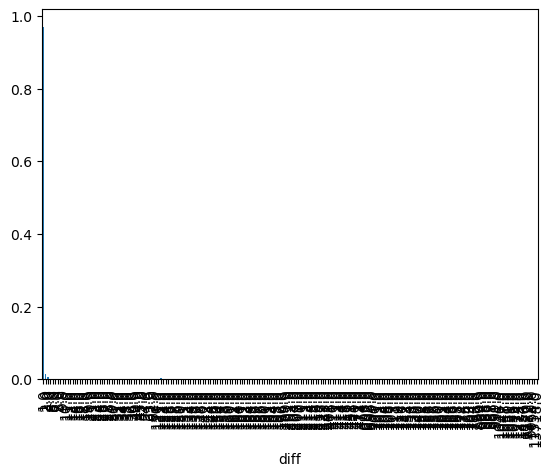

In [454]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [458]:
(df['diff'] < 2).mean()

0.9699099920990059

In [460]:
#Норм

#### 5.3 1hour

In [465]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    assert df.notnull().all().all(), f'{stock} nulls'
    

100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 805.26it/s]


In [467]:
#Нет дублей и данные отсортированы, нет null's (еще бы)

In [470]:
#Заполняемость

In [474]:


dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
    
    df['diff'] = df['time'].diff() / pd.Timedelta('1 hour')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|███████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 1295.69it/s]


(703758, 6)

<Axes: xlabel='diff'>

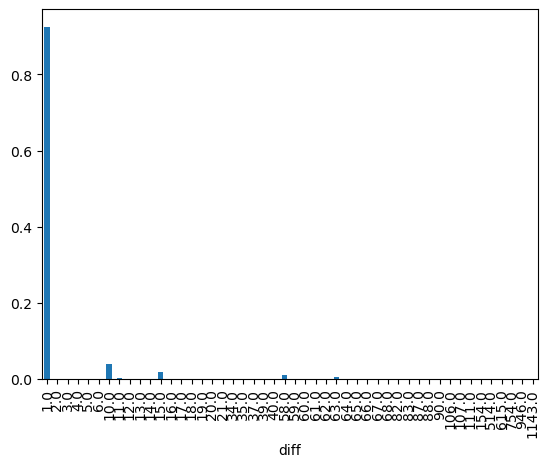

In [476]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [480]:
((df['diff'] < 2) | (df['diff'] == 10) | (df['diff'] == 15) | (df['diff'] == 58)).mean()

0.9908917554045567

In [482]:
#Отлично (не все выходные еще учтены)

#### 5.4 1day

In [487]:
for stock in tqdm(stocks):
    
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

    #print(stock)
    # assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    # assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    # assert df.notnull().all().all(), f'{stock} nulls'

    if not (df['time'].sort_values()  == df['time']).all():
        print(f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}')
        
    if df['time'].duplicated().any():
        print(f'{stock} duplicated: {df['time'].duplicated().sum()}')
        
    if not df.notnull().all().all():
        print(f'{stock} nulls: {df.isnull().sum()}')

100%|███████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 1661.70it/s]


In [491]:
#Нет дублей и данные отсортированы, нет null's (еще бы)

In [493]:
#Заполняемость

In [495]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
    
    df['diff'] = df['time'].diff() / pd.Timedelta('24 hours')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|███████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 2784.29it/s]


(51629, 6)

<Axes: xlabel='diff'>

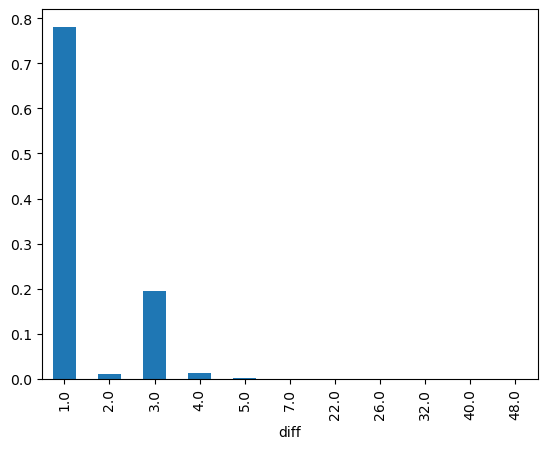

In [497]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [499]:
threshold = 2
(df['diff'] < 4).mean(), (df['diff'] < 5).mean()

(0.9849309496600748, 0.9968041217145402)

In [501]:
#Отлично

# -1. Акции под удаление

In [510]:
#Оставляем только акции, торгующиеся более 1.5 лет
need_days = int(365 * (5/7) * 1.5) 
need_days


391

In [512]:
#1hour
del_stocks_1hour = []

for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

    if df.shape[0] < need_days*14: #14 часов в торг сессии
        del_stocks_1hour += [stock]
        

100%|███████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 2086.31it/s]


In [514]:
len(del_stocks_1hour)

0

In [516]:
del_stocks_1hour

[]

In [519]:
#1day
del_stocks_1day = []

for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

    if df.shape[0] < need_days: #14 часов в торг сессии
        del_stocks_1day += [stock]
        

100%|███████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 7443.39it/s]


In [521]:
len(del_stocks_1day)

0

In [523]:
del_stocks_1day

[]

In [526]:
#Union
del_stocks = set(del_stocks_1hour + del_stocks_1day)

In [528]:
len(del_stocks)

0

In [530]:
del_stocks

set()

In [532]:
#delete
for stock in del_stocks:
    os.remove(f"./data/preproc/1hour/{stock}.pkl")
    os.remove(f"./data/preproc/1day/{stock}.pkl")

In [535]:
import os

In [537]:
[elem.split('.') [0] for elem in os.listdir('./data/preproc/1day/')]

['AFLT',
 'IRAO',
 'MVID',
 'OGKB',
 'SPBE',
 'MTLRP',
 'SFIN',
 'KMAZ',
 'CBOM',
 'FEES',
 'LKOH',
 'FESH',
 'LENT',
 'MDMG',
 'VKCO',
 'UPRO',
 'SELG',
 'SGZH',
 'ENPG',
 'LSRG',
 'BANE',
 'NMTP',
 'PLZL',
 'TATN',
 'AFKS',
 'APTK',
 'GMKN',
 'LIFE',
 'RNFT',
 'YDEX',
 'UWGN',
 'TGKN',
 'HYDR',
 'ABIO',
 'WUSH',
 'RTKMP',
 'GTRK',
 'NLMK',
 'TATNP',
 'ALRS',
 'VSMO',
 'TRNFP',
 'MGNT',
 'RENI',
 'IRKT',
 'MTLR',
 'HEAD',
 'RUAL',
 'TMOS',
 'SIBN',
 'SNGS',
 'NVTK',
 'RASP',
 'VTBR',
 'PHOR',
 'T',
 'TRMK',
 'MOEX',
 'SBERP',
 'CHMF',
 'RTKM',
 'SMLT',
 'UNAC',
 'GAZP',
 'ROSN',
 'BELU',
 'FLOT',
 'PIKK',
 'SVAV',
 'POSI',
 'SNGSP',
 'MTSS',
 'MAGN',
 'SBER',
 'BANEP',
 'BSPB',
 'AQUA']

#### Удалим TMOS

In [543]:
import os
stock = "TMOS"

os.remove(f"./data/preproc/5min/{stock}.pkl")
os.remove(f"./data/preproc/1hour/{stock}.pkl")
os.remove(f"./data/preproc/1day/{stock}.pkl")

### Поправим BELU после сплита

In [550]:
#1 day
stock = "BELU"
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

mask = df['time'] < pd.Timestamp('2024-08-22')
df.loc[mask, 'close'] = df.loc[mask, 'close'] / 8
df.loc[mask, 'volume'] = df.loc[mask, 'volume'] * 8

dump_pkl(df, f"./data/preproc/1day/{stock}.pkl")

In [552]:
#1 hour
df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

mask = df['time'] < pd.Timestamp('2024-08-22')
df.loc[mask, 'close'] = df.loc[mask, 'close'] / 8
df.loc[mask, 'volume'] = df.loc[mask, 'volume'] * 8

dump_pkl(df, f"./data/preproc/1hour/{stock}.pkl")

In [554]:
#15 min
df = load_pkl(f"./data/preproc/5min/{stock}.pkl")

mask = df['time'] < pd.Timestamp('2024-08-22')
df.loc[mask, 'close'] = df.loc[mask, 'close'] / 8
df.loc[mask, 'volume'] = df.loc[mask, 'volume'] * 8

dump_pkl(df, f"./data/preproc/5min/{stock}.pkl")

# -2. Check data

### -2.1 VKCO

In [560]:
#чекнуть сами данные и совпадение с индексом

In [563]:
#5 min

In [567]:
i = -124
stock = "VKCO"

df = load_pkl(f"./data/preproc/5min/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
105538,2025-02-24 13:10:00,337.1,29359.0,VKCO,7.23
105539,2025-02-24 13:15:00,336.6,15035.0,VKCO,7.23


In [569]:
#1hour

df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
9552,2025-02-12 16:00:00,314.7,240594.0,VKCO,6.67
9553,2025-02-12 17:00:00,312.9,390310.0,VKCO,6.64


In [571]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
526,2024-08-27 03:00:00,363.4,1849428.0,VKCO,5.85
527,2024-08-28 03:00:00,358.0,3883924.0,VKCO,5.80


### -2.2 YDEX

In [577]:
#5min
i = -100

stock = "YDEX"
df = load_pkl(f"./data/preproc/5min/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
104696,2025-02-24 15:10:00,4637.0,6304.0,YDEX,7.21
104697,2025-02-24 15:15:00,4640.0,3969.0,YDEX,7.21


In [579]:
#1hour

df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
9497,2025-02-14 13:00:00,4516.0,268798.0,YDEX,7.01
9498,2025-02-14 14:00:00,4584.0,119058.0,YDEX,7.07


In [581]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
546,2024-09-30 03:00:00,4007.5,712975.0,YDEX,6.02
547,2024-10-01 03:00:00,3963.0,747533.0,YDEX,6.00


### -2.3 SNGS

In [590]:
#5 min
i = -32

stock = "SNGS"
df = load_pkl(f"./data/preproc/5min/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
108745,2025-02-24 21:05:00,28.945,3179.0,SNGS,7.27
108746,2025-02-24 21:10:00,28.965,2381.0,SNGS,7.27


In [592]:
#1hour

df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
9986,2025-02-20 21:00:00,28.945,8077.0,SNGS,7.22
9987,2025-02-20 22:00:00,28.985,13212.0,SNGS,7.22


In [594]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
641,2025-01-09 03:00:00,23.865,484701.0,SNGS,6.04
642,2025-01-10 03:00:00,23.400,1596052.0,SNGS,6.19
